In [1]:
import numpy as np
import pandas as pd
global all_wordle_words
import scipy.stats
import itertools
import wordfreq 
from functools import cache

#Only Acceptable Wordle Guesses
url = "https://raw.githubusercontent.com/lightbulbsocks/Rank-One-Wordle/main/All%20Acceptable%20Wordle%20Words.csv"

df1 = pd.read_csv(url,engine='python')

df2 = pd.read_csv('official_wordle_common.csv', engine = 'python')

all_wordle_words = []
for i in range(0,np.size(df1)):
        all_wordle_words.append(df1.iat[i,0].upper())

possible_wordle_words = []
for i in range(0,np.size(df2)):
        possible_wordle_words.append(df2.iat[i,0].upper())

conds = ['y', 'gr', 'gy']
outcomes = np.array([(a,b,c,d,e) for a in conds for b in conds for c in conds for d in conds for e in conds])

In [2]:
def combinations(word, outcomes, possible_wordle_words):
    pot_outcomes = []
    for outcome in outcomes:
        green = []
        yellow = []
        grey = []
        for i in [0,1,2,3,4]:
            if outcome[i] == 'gr':
                green.append((word[i], i))
            elif outcome[i] == 'y':
                yellow.append((word[i], i))
            elif outcome[i] == 'gy':
                grey.append(word[i])
        no_of_outcomes = no_of_possible_words(possible_wordle_words, green, yellow, grey)
        pot_outcomes.append(no_of_outcomes)
    return pot_outcomes

def no_of_possible_words(possible_words, green, yellow, grey):
    copy = possible_words.copy()
    count = 0
    for word in copy[:]:
        test = True
        for (x,y) in green:
            if word[y] != x:
                test = False
                break
        if test:
            for x in grey:
                if x in word:
                    test = False
                    break
        if test:
            for (x,y) in yellow:
                if x in word:
                    if word[y] != x:
                        test = False
                        break
                else:
                     test = False
                     break
        if test:             
            count += 1
    return count

def calc_entropy_of_word(possible_words, green, yellow, grey):
    words_left = edit_possible_words(possible_words, green, yellow, grey)
    entropy = 0
    sum_of_probs = 0
    for each_word in words_left:
        x = wordfreq.word_frequency(each_word, 'en')
        sum_of_probs += x
    for each_word in words_left:
        x = wordfreq.word_frequency(each_word, 'en')
        entropy += x/sum_of_probs * np.log2(sum_of_probs/x)
    return entropy

def edit_possible_words(possible_words, green, yellow, grey):
    copy = possible_words
    for (x,y) in green:
        for word in possible_words[:]:
            if word[y] == x: 
                pass
            else:
                copy.remove(word)
    
    for (x,y) in yellow:
        for word in possible_words[:]:
            if x in word: 
                if word[y] == x: 
                    copy.remove(word)
                else:
                    pass
            else:
                copy.remove(word)
    
    for x in grey:
        for word in possible_words[:]:
            if x in word:
                copy.remove(word)
        
    return copy

def calc_entroy(word, possible_wordle_words):
    entropy = 0
    pot_outcomes = combinations(word, outcomes, possible_wordle_words)
    for x in pot_outcomes:
        if x!=0:
            entropy += x/sum(pot_outcomes) * np.log2(sum(pot_outcomes)/x)
    return (word,entropy)

def eval_outcomes(possible_words):
    outcomes = []
    for word in possible_words:
        outcomes.append(calc_entroy(word))
    return outcomes

def det_conds(guess, secret_word):
    #get greys
    grey = []
    for x in guess:
        if x in secret_word:
            pass
        else:
            grey.append(x)

    #get greens 
    green = []
    yellow = []
    for i in [0,1,2,3,4]:
        if guess[i] == secret_word[i]:
            green.append((guess[i], i))
        else:
            if guess[i] in grey:
                pass
            else:
                yellow.append((guess[i], i))

    return green, yellow, grey


In [3]:
def play_wordle(secret_word):
    guess = ''
    attempt = 1
    possible_words = all_wordle_words.copy()
    possible_wordle_words2 = possible_wordle_words.copy()
    daf2 = pd.read_csv('entropy_outcomes.csv', engine = 'python')
    while True:
        print('Attempt:', attempt)
        if attempt == 1:
            guess = daf2.iloc[0]
            guess = guess[1:]
        else:
            ent_outcomes = []
            for word in possible_words:
                ent_outcomes.append(calc_entroy(word, possible_wordle_words2))
            daf3 = pd.DataFrame(ent_outcomes, columns = ['word', 'entropy'])
            daf3 = daf3.sort_values(by = 'entropy', ascending = False)
            guess = daf3.iloc[0]

            possible_words = edit_possible_words(possible_words, green, yellow, grey)
        print('GUESSED ' , guess[0] , 'with entropy ', guess[1])
        green, yellow, grey = det_conds(guess[0], secret_word)
        possible_words = edit_possible_words(possible_words, green, yellow, grey)
        possible_wordle_words2 = edit_possible_words(possible_wordle_words2, green, yellow, grey)    
        print('-----------------------------------------------------------------------------------')
        if guess[0] == secret_word:
                break
        else:
            attempt += 1
    print('GUESSED IN ' + str(attempt) + ' ATTEMPTS')
    print('-----------------------------------------------------------------------------------')
    return attempt


In [4]:
def testPastWords():
        df3 = pd.read_csv('past_wordles_220.csv', engine = 'python')

        past_wordle_words = []
        for i in range(0,np.size(df3)):
                past_wordle_words.append(df3.iat[i,0].upper())

        results = []
        for word in past_wordle_words:
                results.append(play_wordle(word))
        
        res = np.array(results)
        Dataframe = pd.DataFrame(res)
        Dataframe.to_csv('results.csv')

In [5]:
play_wordle('LEVEL')

Attempt: 1
GUESSED  SHARE with entropy  6.598413535237361
-----------------------------------------------------------------------------------
Attempt: 2
GUESSED  BEVEL with entropy  6.3238561897747365
-----------------------------------------------------------------------------------
Attempt: 3
GUESSED  LEVEL with entropy  5.0
-----------------------------------------------------------------------------------
GUESSED IN 3 ATTEMPTS
-----------------------------------------------------------------------------------


3

RuntimeError: matplotlib2tikz has been renamed to tikzplotlib <https://pypi.org/project/tikzplotlib>

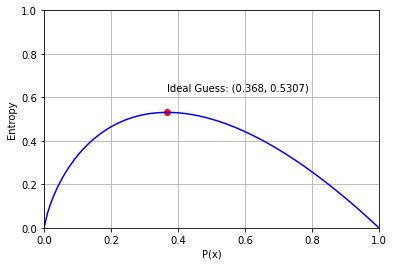

In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np

plt.ylabel("Entropy")
plt.xlabel("P(x)")

plt.grid()

x = np.linspace(0.0001, 1, 100)

def f(x):
    return x*math.log2(1/x)

t = [f(a) for a in x]

plt.plot(x, t, color='blue', linestyle='-', label='Entropy of guesses')


plt.xlim(0,1)
plt.ylim(0,1)


plt.annotate('Ideal Guess: (0.368, 0.5307)', (0.368, 0.5307),  xytext=(0.368, 0.6307))
plt.scatter(0.368, 0.5307, color='red')

# print(equation)

import tikzplotlib

tikzplotlib.save("test.tex")

plt.savefig('Graph8.pdf')



plt.show()